In [7]:
import pandas as pd
import yaml
SOL_ROOT = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint_err_seg'
NO_MERGE_ROOT = '/home/ddon0001/PhD/experiments/scaled/no_merges_all'
SCALES_PATH = '/home/ddon0001/PhD/data/cell_tracking_challenge/scales.yaml'

ds_summary = pd.read_csv(f'{SOL_ROOT}/summary.csv')
with open(SCALES_PATH, 'r') as f:
    scales = yaml.safe_load(f)

In [8]:
EDGE_FN = 'EdgeFlag.FALSE_NEG'
EDGE_FP = 'EdgeFlag.FALSE_POS'
EDGE_WS = 'EdgeFlag.WRONG_SEMANTIC'

NODE_FN = 'NodeFlag.FALSE_NEG'
NODE_FP = 'NodeFlag.FALSE_POS'
NODE_NS = 'NodeFlag.NON_SPLIT'

def has_adjacent_error_edges(sol, node):
    if any(sol[edge][EDGE_FP] or sol[edge][EDGE_WS] for edge in sol.in_edges(node)):
        return True
    if any(sol[edge][EDGE_FP] or sol[edge][EDGE_WS] for edge in sol.out_edges(node)):
        return True
    return False

In [9]:
from collections import defaultdict
import json
import os
import networkx as nx

total_fn = defaultdict(lambda : 0)
total_edges = defaultdict(lambda : 0)
all_edge_count = defaultdict(lambda : 0)
ds_names = []
us = []
gt_us = []
merge_vs = []
true_successors = []
correct_fate = []
is_immediate_split = []

count_should_divide = defaultdict(lambda : 0)
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_gt.graphml')
    no_merge_gt_pth = os.path.join(NO_MERGE_ROOT, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    no_merge_sol_pth = os.path.join(NO_MERGE_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(SOL_ROOT, ds_name, 'matching.json')
    
    
    merge_gt = nx.read_graphml(gt_solution_path)
    no_merge_gt = nx.read_graphml(no_merge_gt_pth)
    merge_g = nx.read_graphml(solution_path, node_type=int)
    no_merge_g = nx.read_graphml(no_merge_sol_pth, node_type=int)
    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    total_fn[ds_name] = len([node for node in merge_gt.nodes if merge_gt.nodes[node][NODE_FN]])
    all_edge_count[ds_name] = merge_gt.number_of_edges()
    for merge_node in merge_g.nodes:
        # we have a merge vertex
        if merge_g.in_degree(merge_node) > 1:
            parents = merge_g.predecessors(merge_node)
            node_gt = sol_to_gt[merge_node]
            for parent in parents:
                # # should this parent be dividing?
                # gt_parent = sol_to_gt[parent]
                # if merge_gt.out_degree(gt_parent) > 1:
                #     assert merge_g.out_degree(parent) <= 1
                #     count_should_divide[ds_name] += 1
                # continue
                edge_of_interest = (parent, merge_node)
                # this edge doesn't exist in gt
                if merge_g.edges[edge_of_interest][EDGE_FP]:
                    ds_names.append(ds_name)
                    us.append(parent)
                    merge_vs.append(merge_node)
                    total_edges[ds_name] += 1
                    if merge_g.out_degree(merge_node) > 1:
                        is_immediate_split.append(True)
                    else:
                        is_immediate_split.append(False)
                    
                    # so what does gt_parent usually do?
                    gt_parent = sol_to_gt[parent]
                    gt_us.append(gt_parent)
                    gt_kids = list(merge_gt.successors(gt_parent))
                    n_kids = len(gt_kids)
                    if n_kids == 0:
                        # "parent" should be terminating
                        true_successors.append('-4')
                        correct_fate.append('terminate')
                        continue
                    elif n_kids == 1:
                        kid = gt_kids[0]
                        if merge_gt.nodes[kid]['t'] > merge_gt.nodes[gt_parent]['t'] + 1:
                            # "parent" is frame skipping
                            true_successors.append(kid)
                            correct_fate.append('skip')
                            continue
                        else:
                            # we're missing this vertex
                            if merge_gt.nodes[kid][NODE_FN]:
                                true_successors.append(kid)
                                correct_fate.append('introduce')
                                continue
                            else:
                                # "parent" should be migrating normally elsewhere
                                true_successors.append(kid)
                                correct_fate.append('migrate')
                                continue
                    raise ValueError(f'Parent {parent} fate missing!')
                    #     # parent is splitting into two totally different children
                    #     should_divide[ds_name].append(parent)
merge_fate_df = pd.DataFrame({
    'ds_name': ds_names,
    'u': us,
    'gt_u': gt_us,
    'v': merge_vs,
    'gt_vs': true_successors,
    'correct_fate': correct_fate,
    'is_immediate_split': is_immediate_split
})

In [10]:
merge_fate_df['new_fate'] = 'Unknown'
merge_fate_df['new_v'] = -1
merge_fate_df['new_v_2'] = -1
merge_fate_df['new_fate_correct'] = False
for ds_name in merge_fate_df['ds_name'].unique():
    original_merge_fps = merge_fate_df[merge_fate_df['ds_name'] == ds_name]

    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    no_merge_sol_pth = os.path.join(NO_MERGE_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(NO_MERGE_ROOT, ds_name, 'matching.json')
    gt_solution_path = os.path.join(NO_MERGE_ROOT, ds_name, 'matched_gt.graphml')
    
    merge_g = nx.read_graphml(solution_path, node_type=int)
    no_merge_g = nx.read_graphml(no_merge_sol_pth, node_type=int)
    gt_g = nx.read_graphml(gt_solution_path)

    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}
    for row in original_merge_fps.itertuples():
        u = row.u
        original_successors = list(merge_g.successors(u))
        new_successors = list(no_merge_g.successors(u))
        if len(new_successors) == 0:
            merge_fate_df.loc[row.Index, 'new_fate'] = 'terminate'
            merge_fate_df.loc[row.Index, 'new_v'] = -4
            if row.correct_fate == 'terminate':
                merge_fate_df.loc[row.Index, 'new_fate_correct'] = True
        elif len(new_successors) == 1:
            merge_fate_df.loc[row.Index, 'new_fate'] = 'migrate'
            merge_fate_df.loc[row.Index, 'new_v'] = new_successors[0]
            if row.correct_fate == 'migrate' and row.gt_vs == sol_to_gt[new_successors[0]]:
                merge_fate_df.loc[row.Index, 'new_fate_correct'] = True
        elif len(new_successors) == 2:
            shared_successors = set(original_successors).intersection(set(new_successors))
            if len(shared_successors) == 2:
                raise ValueError(f'{ds_name} vertex {u} still has the same two successors.')
            elif len(shared_successors) == 1:
                # we share one successor and swapped the other one.
                # is the shared successor the merge vertex?
                if shared_successors.pop() == row.v:
                    raise(ValueError(f'{ds_name} vertex {u} still flowing into merge vertex.'))
                other_successor = list(set(original_successors) - shared_successors)[0]
                merge_fate_df.loc[row.Index, 'new_fate'] = 'migrate'
                merge_fate_df.loc[row.Index, 'new_v'] = other_successor
            elif len(shared_successors) == 0:
                # we weren't splitting before but now we are
                if len(original_successors) == 1:
                    merge_fate_df.loc[row.Index, 'new_fate'] = 'new_split'
                # we were always splitting but now it's different
                else:
                    merge_fate_df.loc[row.Index, 'new_fate'] = 'different_split'
                merge_fate_df.loc[row.Index, 'new_v'] = new_successors[0]
                merge_fate_df.loc[row.Index, 'new_v_2'] = new_successors[1]
        else:
            raise ValueError(f'{ds_name} unexpected number of successors for vertex {u}: {len(new_successors)}')


In [11]:
import numpy as np


merge_fate_df['old_cost'] = -1.0
merge_fate_df['new_cost'] = -1.0
merge_fate_df['old_area_prop'] = -1.0
merge_fate_df['new_area_prop'] = -1.0
merge_fate_df['old_chosen_neighbour_rank'] = -1
merge_fate_df['new_chosen_neighbour_rank'] = -1
merge_fate_df['old_sensitivity_diff'] = -1.0
merge_fate_df['new_sensitivity_diff'] = -1.0

# load merge edges with target and non merge edges with target
all_edges_with_target_merge = pd.read_csv(f'{SOL_ROOT}/all_edges_with_target.csv')
all_edges_with_target_no_merge = pd.read_csv(f'{NO_MERGE_ROOT}/all_edges_with_target.csv')
for edge_row in merge_fate_df.itertuples():
    # for each edge, assign the values of their features
    merge_edge = all_edges_with_target_merge[(all_edges_with_target_merge.ds_name == edge_row.ds_name) & (all_edges_with_target_merge.u == edge_row.u) & (all_edges_with_target_merge.v == edge_row.v)]
    if len(merge_edge) == 0:
        print("MISSING MERGE EDGE")
    # assign into df
    merge_fate_df.loc[edge_row.Index, 'old_cost'] = merge_edge.cost.values[0]
    merge_fate_df.loc[edge_row.Index, 'old_area_prop'] = merge_edge.chosen_neighbour_area_prop.values[0]
    merge_fate_df.loc[edge_row.Index, 'old_chosen_neighbour_rank'] = merge_edge.chosen_neighbour_rank.values[0]
    merge_fate_df.loc[edge_row.Index, 'old_sensitivity_diff'] = merge_edge.sensitivity_diff.values[0]

    if edge_row.new_v == -4:
        # need to read the actual "all edges file for this dataset"
        ds_all_edges = pd.read_csv(f'{SOL_ROOT}/{edge_row.ds_name}/all_edges.csv')
        non_merge_edge = ds_all_edges[(ds_all_edges.u == edge_row.u) & (ds_all_edges.v == edge_row.new_v)]
        merge_fate_df.loc[edge_row.Index, 'new_cost'] = non_merge_edge.cost.values[0]
        merge_fate_df.loc[edge_row.Index, 'new_area_prop'] = 0
        merge_fate_df.loc[edge_row.Index, 'new_sensitivity_diff'] = non_merge_edge.sensitivity_diff.values[0]
        # need to rank the neighbour
        all_neighbours_of_u_costs = ds_all_edges[(ds_all_edges.u == edge_row.u) & (ds_all_edges.v >= 0)].cost.values
        all_neighbours_of_u_costs = np.append(all_neighbours_of_u_costs, non_merge_edge.cost.values[0])
        merge_fate_df.loc[edge_row.Index, 'new_chosen_neighbour_rank'] = all_neighbours_of_u_costs.argsort().argsort()[-1]
        continue 

    non_merge_edge = all_edges_with_target_no_merge[(all_edges_with_target_no_merge.ds_name == edge_row.ds_name) & (all_edges_with_target_no_merge.u == edge_row.u) & (all_edges_with_target_no_merge.v == edge_row.new_v)]
    if len(non_merge_edge) == 0:
        print("MISSING NON MERGE EDGE")
    merge_fate_df.loc[edge_row.Index, 'new_cost'] = non_merge_edge.cost.values[0]
    merge_fate_df.loc[edge_row.Index, 'new_area_prop'] = non_merge_edge.chosen_neighbour_area_prop.values[0]
    merge_fate_df.loc[edge_row.Index, 'new_chosen_neighbour_rank'] = non_merge_edge.chosen_neighbour_rank.values[0]
    merge_fate_df.loc[edge_row.Index, 'new_sensitivity_diff'] = non_merge_edge.sensitivity_diff.values[0]
merge_fate_df.to_csv('/home/ddon0001/PhD/experiments/merge_resolution/merge_fates.csv', index=False)

In [3]:
import pandas as pd
merge_fate_df = pd.read_csv('/home/ddon0001/PhD/experiments/merge_resolution/merge_fates.csv')

In [25]:
merge_fate_df[merge_fate_df.ds_name == 'BF-C2DL-MuSC_01']

,ds_name,u,gt_u,v,gt_vs,correct_fate,is_immediate_split,new_fate,new_v,new_v_2,...,old_area_prop,new_area_prop,old_chosen_neighbour_rank,new_chosen_neighbour_rank,old_sensitivity_diff,new_sensitivity_diff,chosen_rank_diff,sensitivity_diff_diff,area_prop_diff,cost_diff
65,BF-C2DL-MuSC_01,1516,15_1103,1522,16_1105,skip,True,migrate,1522,-1,...,1.811644,1.811644,0,0,15.346190,0.773517,0,-14.572673,0.000000,0.000000
66,BF-C2DL-MuSC_01,2697,29_1229,2710,124_1232,skip,False,migrate,2710,-1,...,1.713873,1.713873,0,0,55.446743,2.551469,0,-52.895275,0.000000,0.000000
67,BF-C2DL-MuSC_01,3648,26_1289,3666,26_1290,introduce,False,terminate,-4,-1,...,2.608491,0.000000,0,2,54.465911,104.046945,2,49.581034,-2.608491,104.046945
68,BF-C2DL-MuSC_01,3737,26_1294,3756,119_1298,skip,False,terminate,-4,-1,...,2.241611,0.000000,0,2,0.733147,70.908265,2,70.175118,-2.241611,71.715569
69,BF-C2DL-MuSC_01,3763,59_1295,3780,60_1297,skip,True,migrate,3782,-1,...,0.945355,4.308743,0,2,54.360273,4.692459,2,-49.667814,3.363388,58.768416
70,BF-C2DL-MuSC_01,3818,60_1298,3836,62_1300,skip,True,migrate,3836,-1,...,2.008621,2.008621,0,0,12.091436,0.361922,0,-11.729515,0.000000,0.000000
71,BF-C2DL-MuSC_01,3844,119_1300,3863,117_1304,skip,False,terminate,-4,-1,...,3.140449,0.000000,0,2,1.653181,31.454354,2,29.801173,-3.140449,57.702408
72,BF-C2DL-MuSC_01,3871,62_1301,3888,118_1303,skip,True,migrate,3888,-1,...,5.682540,5.682540,0,0,3.311771,1.619219,0,-1.692551,0.000000,0.000000
73,BF-C2DL-MuSC_01,3919,56_1304,3938,116_1308,skip,False,terminate,-4,-1,...,2.950355,0.000000,0,5,63.480946,128.897269,5,65.416323,-2.950355,128.897269
74,BF-C2DL-MuSC_01,3990,117_1308,4009,117_1309,introduce,False,migrate,4008,-1,...,2.169096,0.635569,0,1,8.763332,4.557567,1,-4.205765,-1.533528,0.324849


In [12]:
merge_fate_df.groupby('correct_fate').new_fate.value_counts()

correct_fate  new_fate 
introduce     migrate      249
              terminate    137
migrate       migrate       23
              terminate      2
skip          migrate       37
              terminate      8
terminate     migrate       65
              terminate     61
Name: count, dtype: int64

In [13]:
merge_fate_df.groupby('is_immediate_split').correct_fate.value_counts()

is_immediate_split  correct_fate
False               introduce       110
                    terminate       105
                    skip             23
                    migrate          19
True                introduce       276
                    skip             22
                    terminate        21
                    migrate           6
Name: count, dtype: int64

In [26]:
merge_fate_df.is_immediate_split.value_counts()

is_immediate_split
True     325
False    257
Name: count, dtype: int64

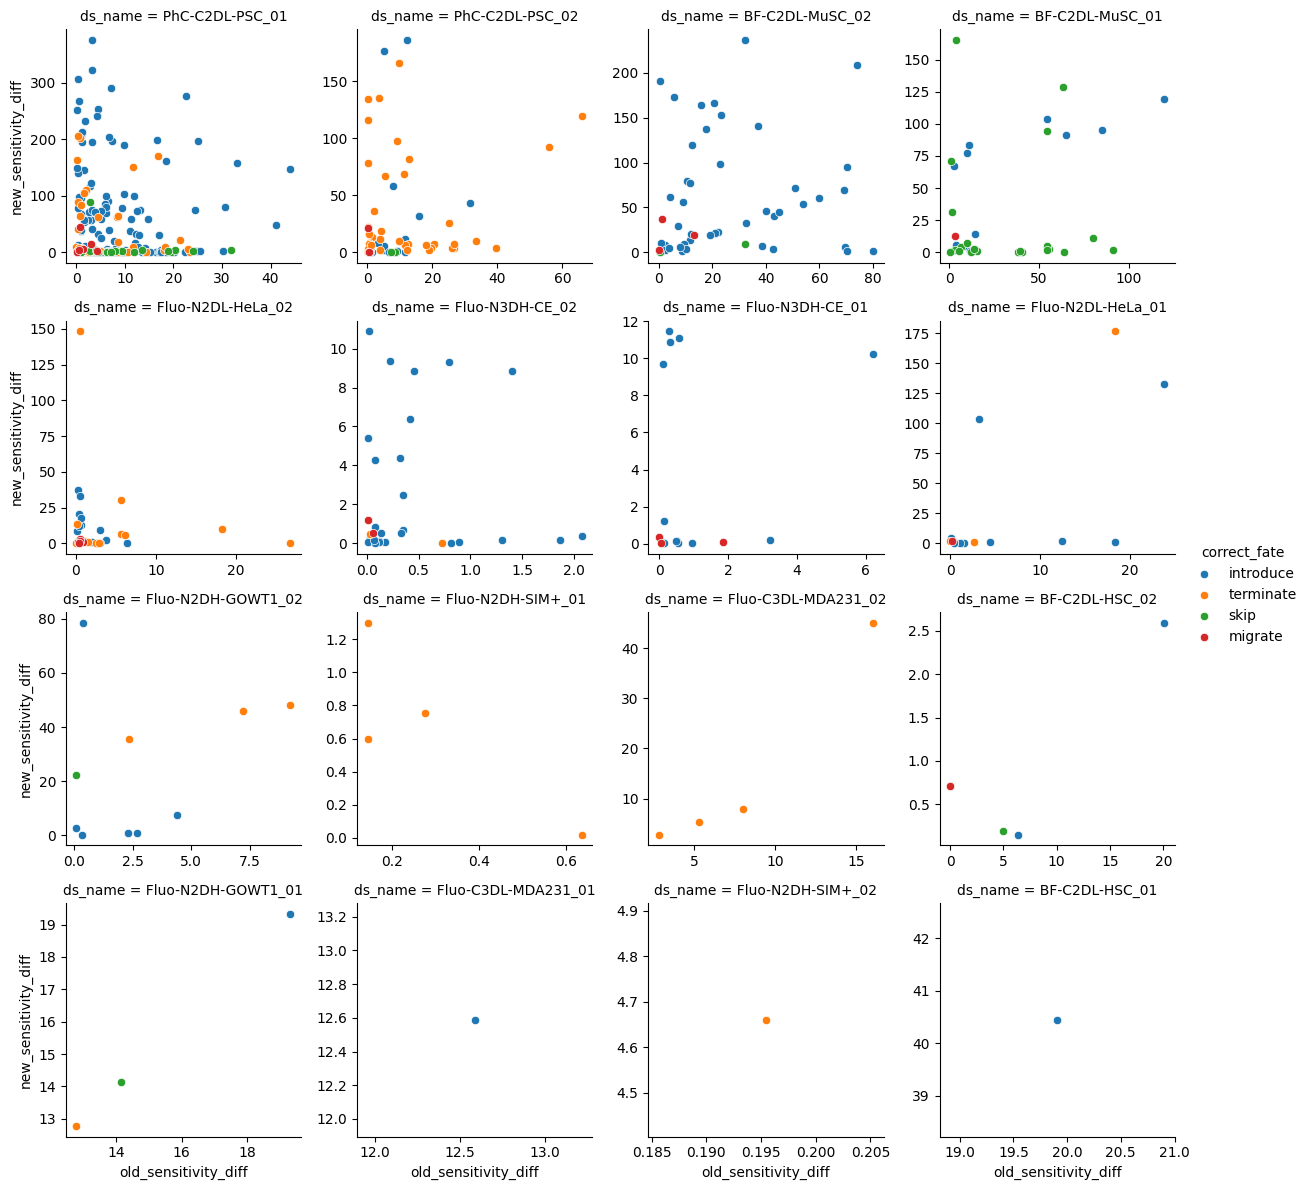

In [21]:
import seaborn as sns

plot_order = merge_fate_df.ds_name.value_counts().index
merge_fate_df['chosen_rank_diff'] = merge_fate_df.new_chosen_neighbour_rank - merge_fate_df.old_chosen_neighbour_rank
merge_fate_df['sensitivity_diff_diff'] = merge_fate_df.new_sensitivity_diff - merge_fate_df.old_sensitivity_diff
merge_fate_df['area_prop_diff'] = merge_fate_df.new_area_prop - merge_fate_df.old_area_prop
merge_fate_df['cost_diff'] = merge_fate_df.new_cost - merge_fate_df.old_cost

grid = sns.FacetGrid(merge_fate_df, col='ds_name', col_order=plot_order, col_wrap=4, hue='correct_fate', sharex=False, sharey=False)
# grid.map(sns.scatterplot, 'old_cost', 'new_cost')
# grid.map(sns.scatterplot, 'old_area_prop', 'new_area_prop')
# grid.map(sns.scatterplot, 'old_chosen_neighbour_rank', 'new_chosen_neighbour_rank')
grid.map(sns.scatterplot, 'old_sensitivity_diff', 'new_sensitivity_diff')

# grid.map(sns.countplot, 'chosen_rank_diff')
# grid.map(sns.histplot, 'cost_diff')
# grid.map(sns.histplot, 'area_prop_diff')
# grid.map(sns.histplot, 'sensitivity_diff_diff')
grid.add_legend()

In [15]:
# merge_fate_df[merge_fate_df.chosen_rank_diff == 0].correct_fate.value_counts()
merge_fate_df[merge_fate_df.v == merge_fate_df.new_v].correct_fate.value_counts()


correct_fate
introduce    65
terminate    23
skip         22
migrate       4
Name: count, dtype: int64

In [ ]:
# how many skip frames have we "correctly" captured through merge and split?
from collections import defaultdict
import json
import os
import networkx as nx

ds_names = []
count_skip = []
count_fn_adjacent = []
count_correctly_merged = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(SOL_ROOT, ds_name, 'matching.json')
    
    merge_gt = nx.read_graphml(gt_solution_path)
    merge_g = nx.read_graphml(solution_path, node_type=int)

    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    skip_edges = [edge for edge in merge_gt.edges if merge_gt.nodes[edge[0]]['t'] < merge_gt.nodes[edge[1]]['t'] - 1]
    count_correct = 0
    count_fn = 0
    for edge in skip_edges:
        if edge[0] not in gt_to_sol or edge[1] not in gt_to_sol:
            count_fn += 1
            continue
        sol_parent = gt_to_sol[edge[0]]
        sol_child = gt_to_sol[edge[1]]
        # we want parent to be flowing into a merge
        if merge_g.out_degree(sol_parent) == 1:
            successor = list(merge_g.successors(sol_parent))[0]
            if merge_g.in_degree(successor) > 1:
                # sol_parent is flowing into a merge - follow the merge to its end
                v = successor
                children = list(merge_g.successors(v))
                while len(children) == 1:
                    v = children[0]
                    children = list(merge_g.successors(v))
                # we've either split or we've terminated
                if len(children) > 1:
                    # we've split - are any of the children sol_child?
                    if any(child == sol_child for child in children):
                        count_correct += 1
    ds_names.append(ds_name)
    count_correctly_merged.append(count_correct)
    count_skip.append(len(skip_edges))
    count_fn_adjacent.append(count_fn)
skip_merges = pd.DataFrame({
    'ds_name': ds_names,
    'total_skips': count_skip,
    'fn_adjacent': count_fn_adjacent,
    'total_correct': count_correctly_merged
})


In [ ]:
skip_merges

In [ ]:
skip_merges.to_csv(os.path.join(SOL_ROOT, 'skip_merges.csv'))

In [31]:
# how long do merges continue for

ds_names = []
merge_id = []
length_of_merge = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    merge_g = nx.read_graphml(solution_path, node_type=int)

    merges = [node for node in merge_g.nodes if merge_g.in_degree(node) > 1]

    for merge_node in merges:
        current_length_of_merge = 0
        children = list(merge_g.successors(merge_node))
        v = merge_node
        while len(children) == 1:
            v = children[0]
            current_length_of_merge += 1
            children = list(merge_g.successors(v))
        ds_names.append(ds_name)
        merge_id.append(merge_node)
        length_of_merge.append(current_length_of_merge)
length_df = pd.DataFrame({
    'ds_name': ds_names,
    'merge_id': merge_id,
    'length': length_of_merge
})


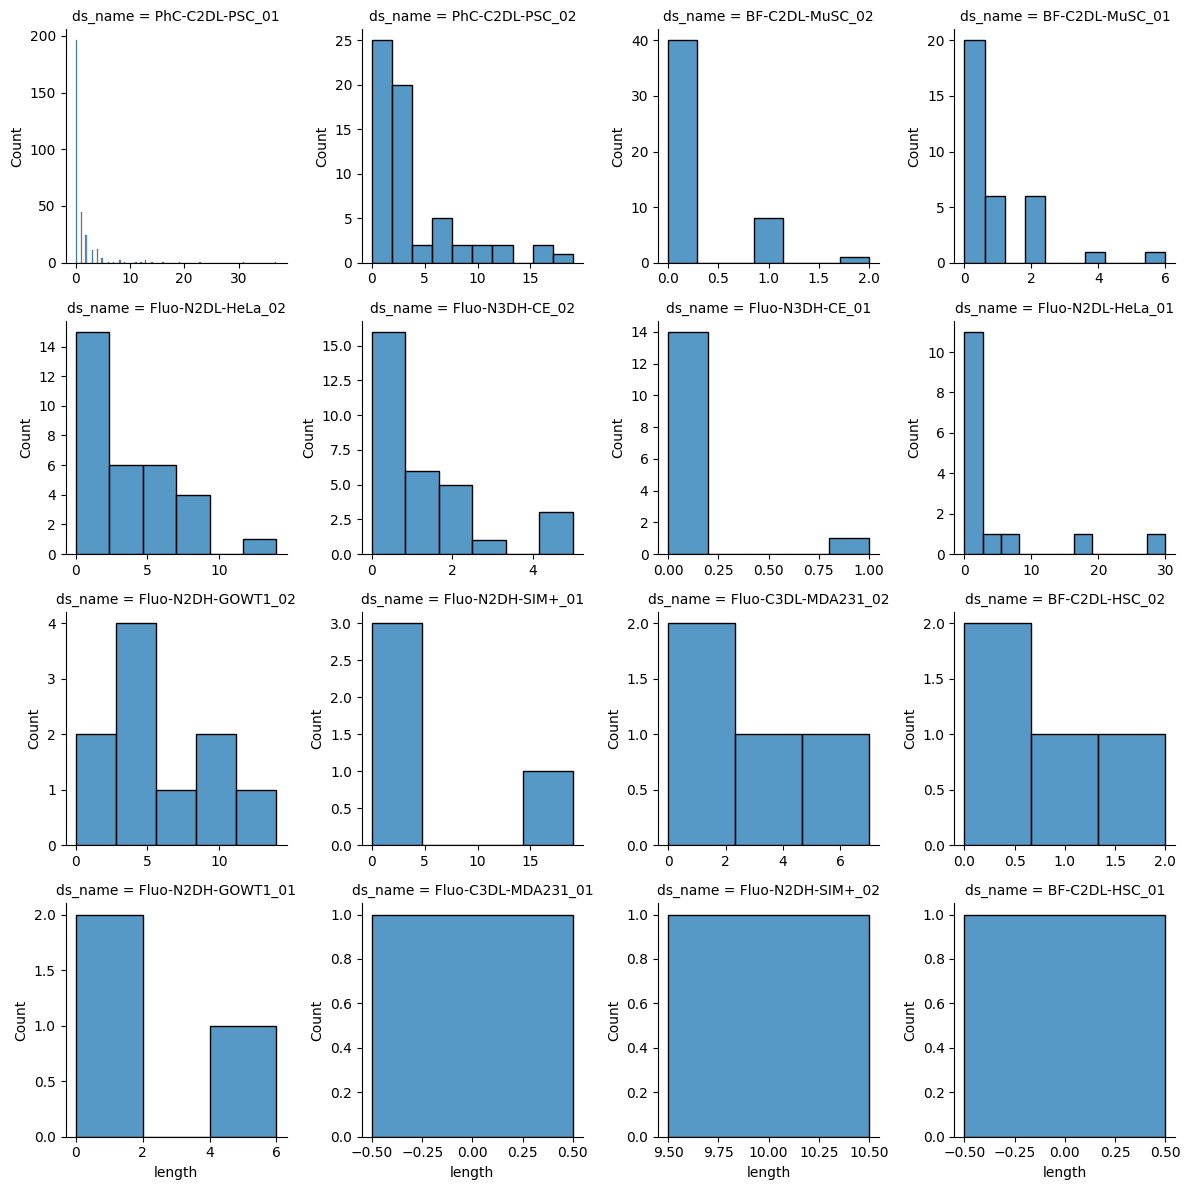

In [38]:
import seaborn as sns

plot_order = length_df.ds_name.value_counts().index
grid = sns.FacetGrid(length_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.histplot, 'length')

In [ ]:
length_df.to_csv('/home/ddon0001/PhD/experiments/merge_resolution/merge_lengths.csv')

In [48]:
merge_fate_df = merge_fate_df.merge(length_df, left_on=['ds_name', 'v'], right_on=['ds_name', 'merge_id'], how='left')

In [54]:
(merge_fate_df[merge_fate_df.correct_fate == 'introduce'].length <= 2).sum()
len(merge_fate_df[merge_fate_df.correct_fate == 'introduce'])

386

In [55]:
merge_fate_df.to_csv('/home/ddon0001/PhD/experiments/merge_resolution/merge_fates.csv', index=False)

In [27]:
# how many merges correctly fuel divisions?

ds_names = []
total_merges = []
# looking at the fate of the merge now
count_correct_division = []
count_incorrect_division = []
count_terminating_correct = []
count_terminating_incorrect = []
total_explained = []
length_of_merge = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(SOL_ROOT, ds_name, 'matching.json')
    
    merge_gt = nx.read_graphml(gt_solution_path)
    merge_g = nx.read_graphml(solution_path, node_type=int)

    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    merges = [node for node in merge_g.nodes if merge_g.in_degree(node) > 1]
    total = len(merges)
    n_correct = 0
    n_incorrect = 0
    n_terminating_correct = 0
    n_terminating_incorrect = 0
    current_length_of_merge = 0

    for merge_node in merges:
        children = list(merge_g.successors(merge_node))
        v = merge_node
        while len(children) == 1:
            v = children[0]
            children = list(merge_g.successors(v))
            current_length_of_merge += 1
        if len(children) == 0:
            gt_term = sol_to_gt[v]
            # gt node also terminates
            if len(list(merge_gt.successors(gt_term))) == 0:
                n_terminating_correct += 1
            else:
                n_terminating_incorrect += 1
        elif len(children) > 1:
            div_edges = [(v, child) for child in children]
            # are any edges wrong?
            if any(merge_g.edges[edge][EDGE_FP] or merge_g.edges[edge][EDGE_WS] for edge in div_edges):
                n_incorrect += 1
            else:
                n_correct += 1
    ds_names.append(ds_name)
    total_merges.append(total)
    count_correct_division.append(n_correct)
    count_incorrect_division.append(n_incorrect)
    count_terminating_correct.append(n_terminating_correct)
    count_terminating_incorrect.append(n_terminating_incorrect)
    length_of_merge.append(current_length_of_merge)
    total_explained.append(n_correct + n_incorrect + n_terminating_correct + n_terminating_incorrect)
merge_fates = pd.DataFrame({
    'ds_name': ds_names,
    'total_merges': total_merges,
    'total_explained': total_explained,
    'correct_division': count_correct_division,
    'incorrect_division': count_incorrect_division,
    'terminating_correct': count_terminating_correct,
    'terminating_incorrect': count_terminating_incorrect,
    'length_of_merge': length_of_merge
})


In [ ]:
merge_fates[merge_fates['total_merges'] > 0] 

In [ ]:
# symmetry/asymmetry of divisions 
import numpy as np


div_diff_dict = {
    'ds_name': [],
    'div_parent_index': [],
    'is_correct': [],
    'is_superparent': [],
    'child_distance_1': [],
    'child_distance_2': [],
    'child_distance_difference': [],
    'interchild_distance': [],
    'div_angle': []
}

# WE TAKE TWO CLOSEST CHILDREN
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    
    merge_g = nx.read_graphml(solution_path, node_type=int)
    location_cols = ['z', 'y', 'x'] if 'z' in merge_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    divs = [node for node in merge_g.nodes if merge_g.out_degree(node) > 1]
    for div in divs:
        children = list(merge_g.successors(div))
        is_superparent = len(children) > 2
        is_correct = not any(merge_g.edges[(div, child)][EDGE_FP] or merge_g.edges[(div, child)][EDGE_WS] for child in children)
        parent_coords = np.asarray([merge_g.nodes[div][col] * scale[i] for i, col in enumerate(location_cols)])
        child_coords = [np.asarray([merge_g.nodes[child][col] * scale[i] for i, col in enumerate(location_cols)]) for child in children]
        child_distances = [np.linalg.norm(parent_coords - child) for child in child_coords]
        dist_indices = np.argsort(child_distances)
        closest_children = [child_coords[i] for i in dist_indices[:2]]
        distances = [child_distances[i] for i in dist_indices[:2]]
        div_angle = np.degrees(np.arccos(
            np.dot(closest_children[0] - parent_coords, closest_children[1] - parent_coords) /
            (distances[0] * distances[1])
        ))
    
        div_diff_dict['ds_name'].append(ds_name)
        div_diff_dict['div_parent_index'].append(div)
        div_diff_dict['is_correct'].append(is_correct)
        div_diff_dict['is_superparent'].append(is_superparent)
        div_diff_dict['child_distance_1'].append(distances[0])
        div_diff_dict['child_distance_2'].append(distances[1])
        div_diff_dict['child_distance_difference'].append(distances[1] - distances[0])
        div_diff_dict['interchild_distance'].append(np.linalg.norm(closest_children[0] - closest_children[1]))
        div_diff_dict['div_angle'].append(div_angle)

div_diff_df = pd.DataFrame(div_diff_dict)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='interchild_distance')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='child_distance_difference')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='div_angle')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.scatterplot, x='div_angle', y='interchild_distance', alpha=0.4)
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.scatterplot, x='div_angle', y='child_distance_difference', alpha=0.4)
grid.add_legend()

In [ ]:
import os
import networkx as nx

# which kth neighbour is chosen for correct migration/incorrect migration
# which kth neighbours are chosen for correct division vs. incorrect division
kth_neighbour_dict = {
    'ds_name': [],
    'source_v': [],
    'dest_v': [],
    'edge_correct': [],
    'neighbour_rank': []
}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')
    
    merge_gt = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edges_path)
    location_cols = ['z', 'y', 'x'] if 'z' in merge_gt.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    for edge in merge_gt.edges:
        source = edge[0]
        dest = edge[1]
        edge_correct = not (merge_gt.edges[edge][EDGE_FP] or merge_gt.edges[edge][EDGE_WS])

        other_edges = all_edges[(all_edges['u'] == source) & (all_edges['v'] >= 0)].sort_values(by='distance').reset_index()
        neighbour_rank = other_edges[other_edges['v'] == dest].index[0]
        kth_neighbour_dict['ds_name'].append(ds_name)
        kth_neighbour_dict['source_v'].append(source)
        kth_neighbour_dict['dest_v'].append(dest)
        kth_neighbour_dict['edge_correct'].append(edge_correct)
        kth_neighbour_dict['neighbour_rank'].append(neighbour_rank)
kth_neighbour_df = pd.DataFrame(kth_neighbour_dict)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(kth_neighbour_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='edge_correct')
grid.map_dataframe(sns.countplot, x='neighbour_rank')
grid.add_legend()

In [ ]:
import seaborn as sns

no_zeros = kth_neighbour_df[kth_neighbour_df['neighbour_rank'] > 0]
grid = sns.FacetGrid(no_zeros, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='neighbour_rank', hue='edge_correct')
grid.add_legend()

In [ ]:
# gt neighbour rank
import os
import networkx as nx
import pandas as pd
import numpy as np
import json

GT_ROOT =  '/home/ddon0001/PhD/experiments/scaled/gt_no_div_constraint'
kth_neighbour_dict = {
    'ds_name': [],
    'source_v': [],
    'dest_v': [],
    'neighbour_rank': []
}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(GT_ROOT, ds_name, 'matched_gt.graphml')
    matching_path = os.path.join(GT_ROOT, ds_name, 'matching.json')
    all_edges_path = os.path.join(GT_ROOT, ds_name, 'all_edges.csv')
    
    merge_gt = nx.read_graphml(solution_path)
    all_edges = pd.read_csv(all_edges_path)
    location_cols = ['x', 'y', 'z'] if 'z' in merge_gt.nodes[list(merge_gt.nodes)[0]] else ['x', 'y']

    with open(matching_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    for edge in merge_gt.edges:
        source = edge[0]
        dest = edge[1]

        sol_source = gt_to_sol[source]
        sol_dest = gt_to_sol[dest]
        other_edges = all_edges[(all_edges['u'] == sol_source) & (all_edges['v'] >= 0)].sort_values(by='distance').reset_index()
        v_edge = other_edges[other_edges['v'] == sol_dest]
        if v_edge.empty:
            neighbour_rank = -1
        else:
            neighbour_rank = v_edge.index[0]
        kth_neighbour_dict['ds_name'].append(ds_name)
        kth_neighbour_dict['source_v'].append(sol_source)
        kth_neighbour_dict['dest_v'].append(sol_dest)
        kth_neighbour_dict['neighbour_rank'].append(neighbour_rank)
gt_neighbour_rank_df = pd.DataFrame(kth_neighbour_dict)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(gt_neighbour_rank_df[gt_neighbour_rank_df['neighbour_rank'] >= 0], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='neighbour_rank')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(gt_neighbour_rank_df[gt_neighbour_rank_df['neighbour_rank'] > 0], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='neighbour_rank')
grid.add_legend()

In [ ]:
# investigating division costs as prop. of migration cost

# cost of correct vs. incorrect edges for divisions vs. migration
import networkx as nx
import numpy as np
import os
from tracktour._tracker import VirtualVertices

chosen_cost_dict = {
    'ds_name': [],
    'div_parent_index': [],
    'is_superparent': [],
    'modified_cost': [],
    'division_cost': [],
    'chosen_children_dist': [],
    # 'cheating_false', 'cheating_true', 'valid_false', 'valid_true'
    'category': [],
}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')

    merge_g = nx.read_graphml(solution_path, node_type=int)
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')
    location_cols = ['z', 'y', 'x'] if 'z' in merge_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    divs = [node for node in merge_g.nodes if merge_g.out_degree(node) > 1]
    for div in divs:
        children = list(merge_g.successors(div))
        is_superparent = len(children) > 2
        is_correct = not any(merge_g.edges[(div, child)][EDGE_FP] or merge_g.edges[(div, child)][EDGE_WS] for child in children)
        parent_coords = np.asarray([merge_g.nodes[div][col] * scale[i] for i, col in enumerate(location_cols)])
        child_coords = [np.asarray([merge_g.nodes[child][col] * scale[i] for i, col in enumerate(location_cols)]) for child in children]
        distances = np.sort([np.linalg.norm(parent_coords - child) for child in child_coords])

        closest_children_dist = distances[0] + distances[1]
        div_edge = all_edges[(all_edges['u'] == VirtualVertices.DIV.value) & (all_edges['v'] == div)]
        div_cost = div_edge['cost'].values[0]
        is_valid = div_edge['flow'].values[0] > 0

        if is_valid:
            if is_correct:
                category = 'valid_true'
            else:
                category = 'valid_false'
        else:
            if is_correct:
                category = 'cheating_true'
            else:
                category = 'cheating_false'

        chosen_cost_dict['ds_name'].append(ds_name)
        chosen_cost_dict['div_parent_index'].append(div)
        chosen_cost_dict['is_superparent'].append(is_superparent)
        # what division cost was incorrectly not chosen? i.e. the false div cost of merged divs?
        chosen_cost_dict['modified_cost'].append(div_cost if is_valid else closest_children_dist)
        chosen_cost_dict['division_cost'].append(div_cost)
        chosen_cost_dict['chosen_children_dist'].append(closest_children_dist)
        chosen_cost_dict['category'].append(category)

chosen_cost_df = pd.DataFrame(chosen_cost_dict)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='category')
grid.map_dataframe(sns.scatterplot, x='modified_cost', y='chosen_children_dist')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='category')
grid.map_dataframe(sns.scatterplot, x='division_cost', y='chosen_children_dist', alpha=0.4)
grid.add_legend()

In [ ]:
import seaborn as sns

chosen_cost_df['is_correct'] = chosen_cost_df.category.str.contains('true')
chosen_cost_df['is_valid'] = chosen_cost_df.category.str.contains('valid')
grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.scatterplot, x='division_cost', y='chosen_children_dist', alpha=0.4)
grid.add_legend()

In [ ]:
grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_valid')
grid.map_dataframe(sns.scatterplot, x='division_cost', y='chosen_children_dist', alpha=0.3)
grid.add_legend()

In [ ]:
solution_path = os.path.join(SOL_ROOT, 'Fluo-N3DH-CE_02', 'matched_solution.graphml')
all_edges_path = os.path.join(SOL_ROOT, 'Fluo-N3DH-CE_02', 'all_edges.csv')

merge_g = nx.read_graphml(solution_path, node_type=int)
all_edges = pd.read_csv(all_edges_path)

In [ ]:
# structural property of tracks - mergeless tracks
from collections import defaultdict
import os
import networkx as nx

all_components = dict()
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')

    merge_g = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edges_path)

    undirected_g = merge_g.to_undirected()
    components = defaultdict(dict)
    for i, component in enumerate(nx.connected_components(undirected_g)):
        components[i]['nodes'] = component
        components[i]['edges'] = list(merge_g.subgraph(component).edges)
        components[i]['total_edges'] = len(components[i]['edges'])
        components[i]['count_nodes'] = len(component)

        has_merges = [merge_g.in_degree(node) > 1 for node in component]
        count_merges = sum(has_merges)
        components[i]['has_merge'] = count_merges > 0
        components[i]['count_merges'] = count_merges

        has_divisions = [merge_g.out_degree(node) > 1 for node in component]
        count_divisions = sum(has_divisions)
        components[i]['has_division'] = count_divisions > 0
        components[i]['count_divisions'] = count_divisions

        wrong_edge = [(merge_g.edges[edge][EDGE_FP] or merge_g.edges[edge][EDGE_WS]) for edge in components[i]['edges']]
        components[i]['count_wrong_edges'] = wrong_edge.count(True)
        components[i]['count_correct_edges'] = wrong_edge.count(False)
        components[i]['is_correct'] = components[i]['count_correct_edges'] == components[i]['total_edges']
    all_components[ds_name] = components

In [ ]:
# ds_name, component_id, has_merge, is_fully_correct, prop_correct_edges
ds_names = []
comp_ids = []
has_merge = []
count_merge = []
has_div = []
count_div = []
is_fully_correct = []
prop_correct_edges = []
total_edges = []
for ds_name, comp_info in all_components.items():
    for comp_id, comp in comp_info.items():
        ds_names.append(ds_name)
        comp_ids.append(comp_id)
        has_merge.append(comp['has_merge'])
        count_merge.append(comp['count_merges'])
        has_div.append(comp['has_division'])
        count_div.append(comp['count_divisions'])
        is_fully_correct.append(comp['is_correct'])
        if comp['total_edges']> 0:
            prop_correct_edges.append(comp['count_correct_edges']/comp['total_edges'])
        else:
            prop_correct_edges.append(0)
        total_edges.append(comp['total_edges'])
component_df = pd.DataFrame({
    'ds_name': ds_names,
    'component': comp_ids,
    'has_merge': has_merge,
    'count_merges': count_merge,
    'has_div': has_div,
    'count_div': count_div,
    'is_correct': is_fully_correct,
    'prop_correct': prop_correct_edges,
    'total_edges': total_edges
})
    

In [ ]:
import os
import networkx as nx
import numpy as np
from tracktour._tracker import VirtualVertices

ds_names = []
node_ids = []
node_areas = []
comp_ids = []
# true if component contains a merge
merge_comp = []
# true if component contains a div
div_comp = []
# true if component is entirely correct
is_correct_comp = []
# true if node is a parent of a division
is_parent = []
# true if node is a parent of 3+ children
is_superparent = []
# true if the node has two incoming edges
is_merge_vertex = []
# -1 if node is not a parent, otherwise difference in distance to (two closest) children
child_distance_difference = []
# -1 if node is not a parent, otherwise sum of distances to (two closest) children
child_distance_sum = []
# -1 if node is not a parent, otherwise distance between two closest children
interchild_distance = []
# -1 if node is not a parent, otherwise angle between two closest children
# arcos of dot product of vectors from parent to children scaled by product of magnitudes
div_angle = []
# True if node is parent and both children are correct, otherwise False
div_correct = []
# True if node is parent and there is division flow into node
div_valid = []
# -1 if node has no successors, otherwise distance rank of the first child
first_chosen_neighbour_rank = []
# -1 if node is not a parent, otherwise distance rank of the second child
second_chosen_neighbour_rank = []
# -1 if node has no successors, otherwise distance to the closest child
first_child_distance = []
# -1 if node is not a parent, otherwise distance to the second closest child
second_child_distance = []
# -1 if node has no successors, otherwise area of the first child
first_child_area = []
# -1 if node is not a parent, otherwise area of the second child
second_child_area = []
# sum of areas of two children if node is parent, otherwise -1
child_area_sum = []
# cost of the Dv edge for node v (regardless of whether it was used)
div_cost = []
# True if node is not a parent, and the edge to its child is correct, otherwise False
mig_correct = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    det_path = row['det_path']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')

    merge_g = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edges_path)
    det_df = pd.read_csv(det_path)
    location_cols = ['z', 'y', 'x'] if 'z' in merge_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    ds_components = all_components[ds_name]
    for comp_id, comp in ds_components.items():
        for node in comp['nodes']:
            ds_names.append(ds_name)
            node_ids.append(node)
            node_areas.append(det_df.loc[node].area)
            comp_ids.append(comp_id)
            merge_comp.append(comp['has_merge'])
            div_comp.append(comp['has_division'])
            is_correct_comp.append(comp['is_correct'])
            is_parent.append(merge_g.out_degree(node) > 1)
            is_superparent.append(merge_g.out_degree(node) > 2)
            is_merge_vertex.append(merge_g.in_degree(node) > 1)

            children = list(merge_g.successors(node))
            parent_coords = np.asarray([merge_g.nodes[node][col] * scale[i] for i, col in enumerate(location_cols)])
            child_coords = [np.asarray([merge_g.nodes[child][col] * scale[i] for i, col in enumerate(location_cols)]) for child in children]
            child_distances = [np.linalg.norm(parent_coords - child) for child in child_coords]
            dist_indices = np.argsort(child_distances)
            children = [children[i] for i in dist_indices]
            closest_children = [child_coords[i] for i in dist_indices]
            distances = [child_distances[i] for i in dist_indices]

            child_dist_diff = -1
            child_dist_sum = -1
            ichild_dist = -1
            ang = -1
            first_neighb = -1
            second_neighb = -1
            first_dist = -1
            second_dist = -1
            first_area = -1
            second_area = -1
            area_sum = -1
            div_cos = -1
            div_corr = False
            div_val = False
            mig_corr = False
            if len(children) > 0:
                # save first child stuff
                other_edges = all_edges[(all_edges['u'] == node) & (all_edges['v'] >= 0)].sort_values(by='distance').reset_index()
                neighbour_ranks = [other_edges[other_edges['v'] == dest].index[0] for dest in children]
                first_neighb = neighbour_ranks[0]
                first_dist = distances[0]
                first_area = det_df.loc[children[0]].area
                if len(children) == 1:
                    mig_corr = (not (merge_g.edges[(node, children[0])][EDGE_FP] or merge_g.edges[(node, children[0])][EDGE_WS]))
                else:
                    ang = np.degrees(np.arccos(
                        np.dot(closest_children[0] - parent_coords, closest_children[1] - parent_coords) /
                        (distances[0] * distances[1])
                    ))
                    div_corr = not any(merge_g.edges[(node, child)][EDGE_FP] or merge_g.edges[(node, child)][EDGE_WS] for child in children)
                    second_neighb = neighbour_ranks[1]
                    second_dist = distances[1]
                    second_area = det_df.loc[children[1]].area
                    area_sum = first_area + second_area
                    child_dist_diff = distances[1] - distances[0]
                    child_dist_sum = distances[1] + distances[0]
                    ichild_dist = np.linalg.norm(closest_children[0] - closest_children[1])
                    div_edge = all_edges[(all_edges['u'] == VirtualVertices.DIV.value) & (all_edges['v'] == node)]
                    if len(div_edge):
                        div_cos = div_edge['cost'].values[0]
                        div_val = div_edge['flow'].values[0] > 0
            child_distance_difference.append(child_dist_diff)
            child_distance_sum.append(child_dist_sum)
            interchild_distance.append(ichild_dist)
            div_angle.append(ang)
            child_area_sum.append(area_sum)
            first_chosen_neighbour_rank.append(first_neighb)
            second_chosen_neighbour_rank.append(second_neighb)
            first_child_distance.append(first_dist)
            first_child_area.append(first_area)
            second_child_distance.append(second_dist)
            second_child_area.append(second_area)
            div_cost.append(div_cos)
            div_correct.append(div_corr)
            div_valid.append(div_val)
            mig_correct.append(mig_corr)
all_node_info = pd.DataFrame({
    'ds_name': ds_names,
    'node_id': node_ids,
    'node_area': node_areas,
    'component_id': comp_ids,
    'comp_merge': merge_comp,
    'comp_div': div_comp,
    'comp_correct': is_correct_comp,
    'is_parent': is_parent,
    'is_superparent': is_superparent,
    'is_merge_vertex': is_merge_vertex,
    'child_distance_difference': child_distance_difference,
    'child_distance_sum': child_distance_sum,
    'interchild_distance': interchild_distance,
    'div_angle': div_angle,
    'child_area_sum': child_area_sum,
    'div_correct': div_correct,
    'div_valid': div_valid,
    'first_chosen_neighbour_rank': first_chosen_neighbour_rank,
    'second_chosen_neighbour_rank': second_chosen_neighbour_rank,
    'first_child_distance': first_child_distance,
    'first_child_area': first_child_area,
    'second_child_distance': second_child_distance,
    'second_child_area': second_child_area,
    'div_cost': div_cost,
    'mig_correct': mig_correct
})
# all_node_info.to_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'), index=False)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df, col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='has_merge')
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df[component_df.has_merge == False], col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='has_div')
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
grid = sns.FacetGrid(component_df[(component_df.has_div == False) & (component_df.has_merge == False)], col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
grid = sns.FacetGrid(component_df[(component_df.has_div == True) & (component_df.has_merge == False)], col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='has_merge')
grid.map_dataframe(sns.histplot, x='total_edges')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df[component_df['total_edges'] > 0], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='has_merge')
grid.map_dataframe(sns.scatterplot, x='total_edges', y='prop_correct')
grid.add_legend()

What else do we want to know about merge vs. mergeless components

- num divisions (correct/incorrect)
- division asymmetry coloured by correct/incorrect merge/mergeless
- angle of division coloured by correct/incorrect merge/mergeless
- sum of cell area vs. parent area coloured by correct/incorrect
- would be good to learn a migration measure from tracks with no divisions
    - how many of these've we got?
- distance from borders?
- specifically looking for discriminators within the mergeless components

In [ ]:
all_info_df = pd.read_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'))

In [ ]:
all_info_df['child_area_prop'] = np.where(all_info_df['child_area_sum'] > 0, all_info_df['child_area_sum'] / all_info_df['node_area'], -1)
all_info_df['neighbour_rank_difference'] = np.where(all_info_df['second_chosen_neighbour_rank'] >= 0, all_info_df['second_chosen_neighbour_rank'] - all_info_df['first_chosen_neighbour_rank'], -1)
all_info_df['neighbour_rank_sum'] = np.where(all_info_df['second_chosen_neighbour_rank'] >= 0, all_info_df['second_chosen_neighbour_rank'] + all_info_df['first_chosen_neighbour_rank'], -1)

In [ ]:
all_info_df.to_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'), index=False)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(all_info_df[all_info_df.is_parent], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='div_correct')
grid.map_dataframe(sns.histplot, x='neighbour_rank_sum')
grid.add_legend()

In [ ]:
all_info_df[all_info_df.first_child_distance >= 0].value_counts('mig_correct')

In [ ]:
all_info_df[all_info_df.second_child_distance >= 0].value_counts('div_correct')

## Exploring Appearance/Disappearance

In [1]:
import pandas as pd
import networkx as nx
import json
import os

sol_root = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint_err_seg'
ds_summary = pd.read_csv(os.path.join(sol_root, 'summary.csv'))
ds_names = ds_summary.ds_name.unique() 

ad_ds_names = []
app_counts = []
sol_app_counts = []
disapp_counts = []
sol_disapp_counts = []
fn_app_counts = []
fn_disapp_counts = []
for ds_name in ds_names:
    solution_path = os.path.join(sol_root, ds_name, 'matched_solution.graphml')
    gt_solution_path = os.path.join(sol_root, ds_name, 'matched_gt.graphml')
    matching_path = os.path.join(sol_root, ds_name, 'matching.json')

    merge_g = nx.read_graphml(solution_path, node_type=int)
    gt_g = nx.read_graphml(gt_solution_path)
    with open(matching_path) as f:
        node_match = json.load(f)
        gt_to_sol = {item[0]: item[1] for item in node_match}
        sol_to_gt = {item[1]: item[0] for item in node_match}
    
    start_frame = 0
    end_frame = ds_summary[ds_summary.ds_name == ds_name].n_frames.values[0] - 1

    appearances = [node for node in gt_g.nodes if gt_g.in_degree(node) == 0 and gt_g.nodes[node]['t'] != 0]
    disappearances = [node for node in gt_g.nodes if gt_g.out_degree(node) == 0 and gt_g.nodes[node]['t'] != end_frame]
    
    is_fn_app = [node for node in appearances if node not in gt_to_sol]
    is_fn_disapp = [node for node in disappearances if node not in gt_to_sol]

    sol_apps = [node for node in merge_g.nodes if merge_g.in_degree(node) == 0 and merge_g.nodes[node]['t'] != 0]
    sol_disapps = [node for node in merge_g.nodes if merge_g.out_degree(node) == 0 and merge_g.nodes[node]['t'] != end_frame]
    
    appearance_count = len(appearances)
    disappearance_count = len(disappearances)

    fn_app_count = len(is_fn_app)
    fn_disapp_count = len(is_fn_disapp)

    sol_app_count = len(sol_apps)
    sol_disapp_count = len(sol_disapps)

    ad_ds_names.append(ds_name)

    app_counts.append(appearance_count)
    disapp_counts.append(disappearance_count)

    fn_app_counts.append(fn_app_count)
    fn_disapp_counts.append(fn_disapp_count)

    sol_app_counts.append(sol_app_count)
    sol_disapp_counts.append(sol_disapp_count)

app_disapp_df = pd.DataFrame({
    'ds_name': ad_ds_names,
    'appearance_count': app_counts,
    'sol_app_count': sol_app_counts,
    'fn_app_count': fn_app_counts,
    'disappearance_count': disapp_counts,
    'sol_disapp_count': sol_disapp_counts,
    'fn_disapp_count': fn_disapp_counts
})
app_disapp_df.sort_values(by='disappearance_count', ascending=False)


,ds_name,appearance_count,sol_app_count,fn_app_count,disappearance_count,sol_disapp_count,fn_disapp_count
29,Fluo-N3DH-CE_02,0,149,0,363,359,2
28,Fluo-N3DH-CE_01,0,36,0,362,362,0
26,PhC-C2DL-PSC_01,128,49,1,122,29,4
27,PhC-C2DL-PSC_02,99,74,3,101,57,1
9,Fluo-N2DL-HeLa_02,127,113,2,99,63,4
8,Fluo-N2DL-HeLa_01,34,32,1,34,18,5
5,Fluo-N2DH-GOWT1_02,20,8,14,21,8,12
1,Fluo-N3DH-SIM+_02,5,80,0,20,55,0
24,Fluo-N2DH-SIM+_01,6,22,0,19,20,0
3,Fluo-C3DL-MDA231_02,7,9,1,14,9,1


In [36]:
import seaborn

def get_appearance_prop(row):
    if row['appearance_count'] == 0:
        if row['sol_app_count'] == 0:
            return 1
        else:
            return row['sol_app_count']
    return row['sol_app_count'] / row['appearance_count']

def get_disappearance_prop(row):
    if row['disappearance_count'] == 0:
        if row['sol_disapp_count'] == 0:
            return 1
        else:
            return row['sol_disapp_count']
    return row['sol_disapp_count'] / row['disappearance_count']

app_disapp_df['appearance_diff_prop'] = app_disapp_df.apply(get_appearance_prop, axis=1)
app_disapp_df['disappearance_diff_prop'] = app_disapp_df.apply(get_disappearance_prop, axis=1)

In [37]:
app_disapp_df[['ds_name', 'appearance_diff_prop']].sort_values(by='appearance_diff_prop', ascending=False)

,ds_name,appearance_diff_prop
29,Fluo-N3DH-CE_02,149.000000
0,Fluo-N3DH-SIM+_01,42.000000
28,Fluo-N3DH-CE_01,36.000000
1,Fluo-N3DH-SIM+_02,16.000000
19,BF-C2DL-MuSC_02,7.000000
16,Fluo-N3DH-CHO_01,6.000000
7,PhC-C2DH-U373_02,6.000000
25,Fluo-N2DH-SIM+_02,5.222222
24,Fluo-N2DH-SIM+_01,3.666667
18,BF-C2DL-MuSC_01,3.000000


In [38]:
app_disapp_df[['ds_name', 'disappearance_diff_prop']].sort_values(by='disappearance_diff_prop', ascending=False)

,ds_name,disappearance_diff_prop
19,BF-C2DL-MuSC_02,8.000000
16,Fluo-N3DH-CHO_01,5.428571
0,Fluo-N3DH-SIM+_01,5.000000
25,Fluo-N2DH-SIM+_02,4.000000
7,PhC-C2DH-U373_02,3.500000
18,BF-C2DL-MuSC_01,3.000000
15,DIC-C2DH-HeLa_02,2.857143
1,Fluo-N3DH-SIM+_02,2.750000
17,Fluo-N3DH-CHO_02,2.700000
13,Fluo-C3DH-H157_02,2.666667


<Axes: xlabel='appearance_diff_prop', ylabel='Count'>

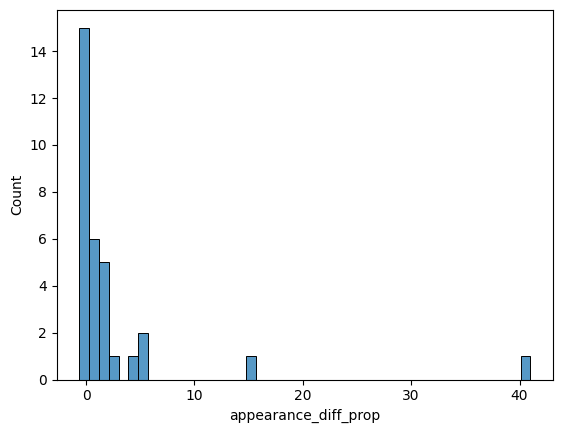

In [9]:
import seaborn as sns

sns.histplot(app_disapp_df, x='appearance_diff_prop')

<Axes: xlabel='disappearance_diff_prop', ylabel='Count'>

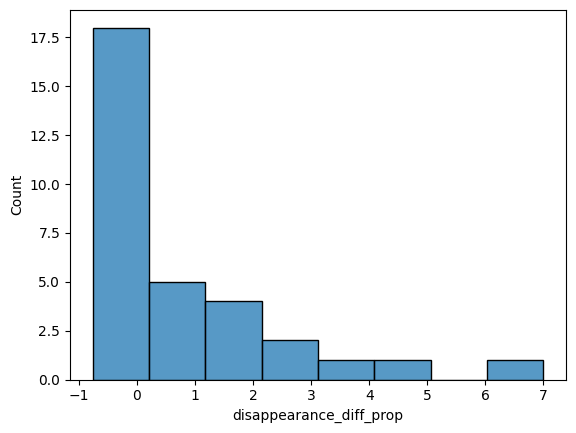

In [10]:
sns.histplot(app_disapp_df, x='disappearance_diff_prop')

In [24]:
import pandas as pd
import networkx as nx
import numpy as np
import json
import os
from tracktour._io_util import read_scale

def get_gt_coords(gt_node_info):
    if 'z' in gt_node_info:
        return np.asarray([gt_node_info['x'], gt_node_info['y'], gt_node_info['z']])
    else:
        return np.asarray([gt_node_info['x'], gt_node_info['y']])

sol_root = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint_err_seg'
ds_summary = pd.read_csv(os.path.join(sol_root, 'summary.csv'))
ds_names = ds_summary.ds_name.unique()

ap_ds_names = []
ap_gt_id = []
ap_sol_id = []
ap_cost = []
ap_is_fn = []
ap_is_correct = []
ap_real_cost = []

disap_ds_names = []
disap_gt_id = []
disap_sol_id = []
disap_cost = []
disap_is_fn = []
disap_is_correct = []
disap_real_cost = []
for ds_name in ds_names:
    solution_path = os.path.join(sol_root, ds_name, 'matched_solution.graphml')
    gt_solution_path = os.path.join(sol_root, ds_name, 'matched_gt.graphml')
    matching_path = os.path.join(sol_root, ds_name, 'matching.json')
    all_edges_path = os.path.join(sol_root, ds_name, 'all_edges.csv')
    scale = read_scale(ds_name)

    merge_g = nx.read_graphml(solution_path, node_type=int)
    gt_g = nx.read_graphml(gt_solution_path)
    with open(matching_path) as f:
        node_match = json.load(f)
        gt_to_sol = {item[0]: item[1] for item in node_match}
        sol_to_gt = {item[1]: item[0] for item in node_match}
    all_edges = pd.read_csv(all_edges_path)
    
    start_frame = 0
    ds_row = ds_summary[ds_summary.ds_name == ds_name]
    end_frame = ds_row.n_frames.values[0] - 1
    im_shape = np.asarray(eval(ds_row.im_shape.values[0]))
    for i, elem in enumerate(im_shape):
        im_shape[i] = elem * scale[i]

    appearances = [node for node in gt_g.nodes if gt_g.in_degree(node) == 0 and gt_g.nodes[node]['t'] != 0]
    disappearances = [node for node in gt_g.nodes if gt_g.out_degree(node) == 0 and gt_g.nodes[node]['t'] != end_frame]

    for app in appearances:
        ap_gt_id.append(app)
        ap_ds_names.append(ds_name)
        if app in gt_to_sol:
            ap_sol_id.append(gt_to_sol[app])
            ap_is_fn.append(False)
            cost = all_edges[(all_edges['u'] == -2) & (all_edges['v'] == gt_to_sol[app])]['cost'].values[0]
            if merge_g.in_degree(gt_to_sol[app]) == 0:
                ap_is_correct.append(True)
                ap_real_cost.append(cost)
            else:
                ap_is_correct.append(False)
                ap_real_cost.append(min([merge_g.edges[edge]['cost'] for edge in merge_g.in_edges(gt_to_sol[app])]))
        else:
            ap_sol_id.append(-1)
            ap_is_fn.append(True)
            dist_to_top_left = get_gt_coords(gt_g.nodes[app])
            for i, coords in enumerate(dist_to_top_left):
                dist_to_top_left[i] = scale[i] * coords
            dist_to_bottom_right = im_shape - dist_to_top_left
            cost = np.min(np.concatenate([dist_to_top_left, dist_to_bottom_right]))
            ap_is_correct.append(False)
            ap_real_cost.append(-1)
        ap_cost.append(cost)

    for disap in disappearances:
        disap_gt_id.append(disap)
        disap_ds_names.append(ds_name)
        if disap in gt_to_sol:
            disap_sol_id.append(gt_to_sol[disap])
            disap_is_fn.append(False)
            cost = all_edges[(all_edges['u'] == gt_to_sol[disap]) & (all_edges['v'] == -4)]['cost'].values[0]
            if merge_g.out_degree(gt_to_sol[disap]) == 0:
                disap_is_correct.append(True)
                disap_real_cost.append(cost)
            else:
                disap_is_correct.append(False)
                disap_real_cost.append(min([merge_g.edges[edge]['cost'] for edge in merge_g.out_edges(gt_to_sol[disap])]))
        else:
            disap_sol_id.append(-1)
            disap_is_fn.append(True)
            dist_to_top_left = get_gt_coords(gt_g.nodes[disap])
            for i, coords in enumerate(dist_to_top_left):
                dist_to_top_left[i] = scale[i] * coords
            dist_to_bottom_right = im_shape - dist_to_top_left
            cost = np.min(np.concatenate([dist_to_top_left, dist_to_bottom_right]))
            disap_is_correct.append(False)
            disap_real_cost.append(-1)
        disap_cost.append(cost)
ap_df = pd.DataFrame({
    'ds_name': ap_ds_names,
    'gt_id': ap_gt_id,
    'sol_id': ap_sol_id,
    'cost': ap_cost,
    'is_fn': ap_is_fn,
    'is_correct': ap_is_correct,
    # min cost of all incoming edges, -1 for fn appearing vertices
    'real_cost': ap_real_cost
})
disap_df = pd.DataFrame({
    'ds_name': disap_ds_names,
    'gt_id': disap_gt_id,
    'sol_id': disap_sol_id,
    'cost': disap_cost,
    'is_fn': disap_is_fn,
    'is_correct': disap_is_correct,
    # min cost of all outgoing edges, -1 for fn disappearing vertices
    'real_cost': disap_real_cost
})

        



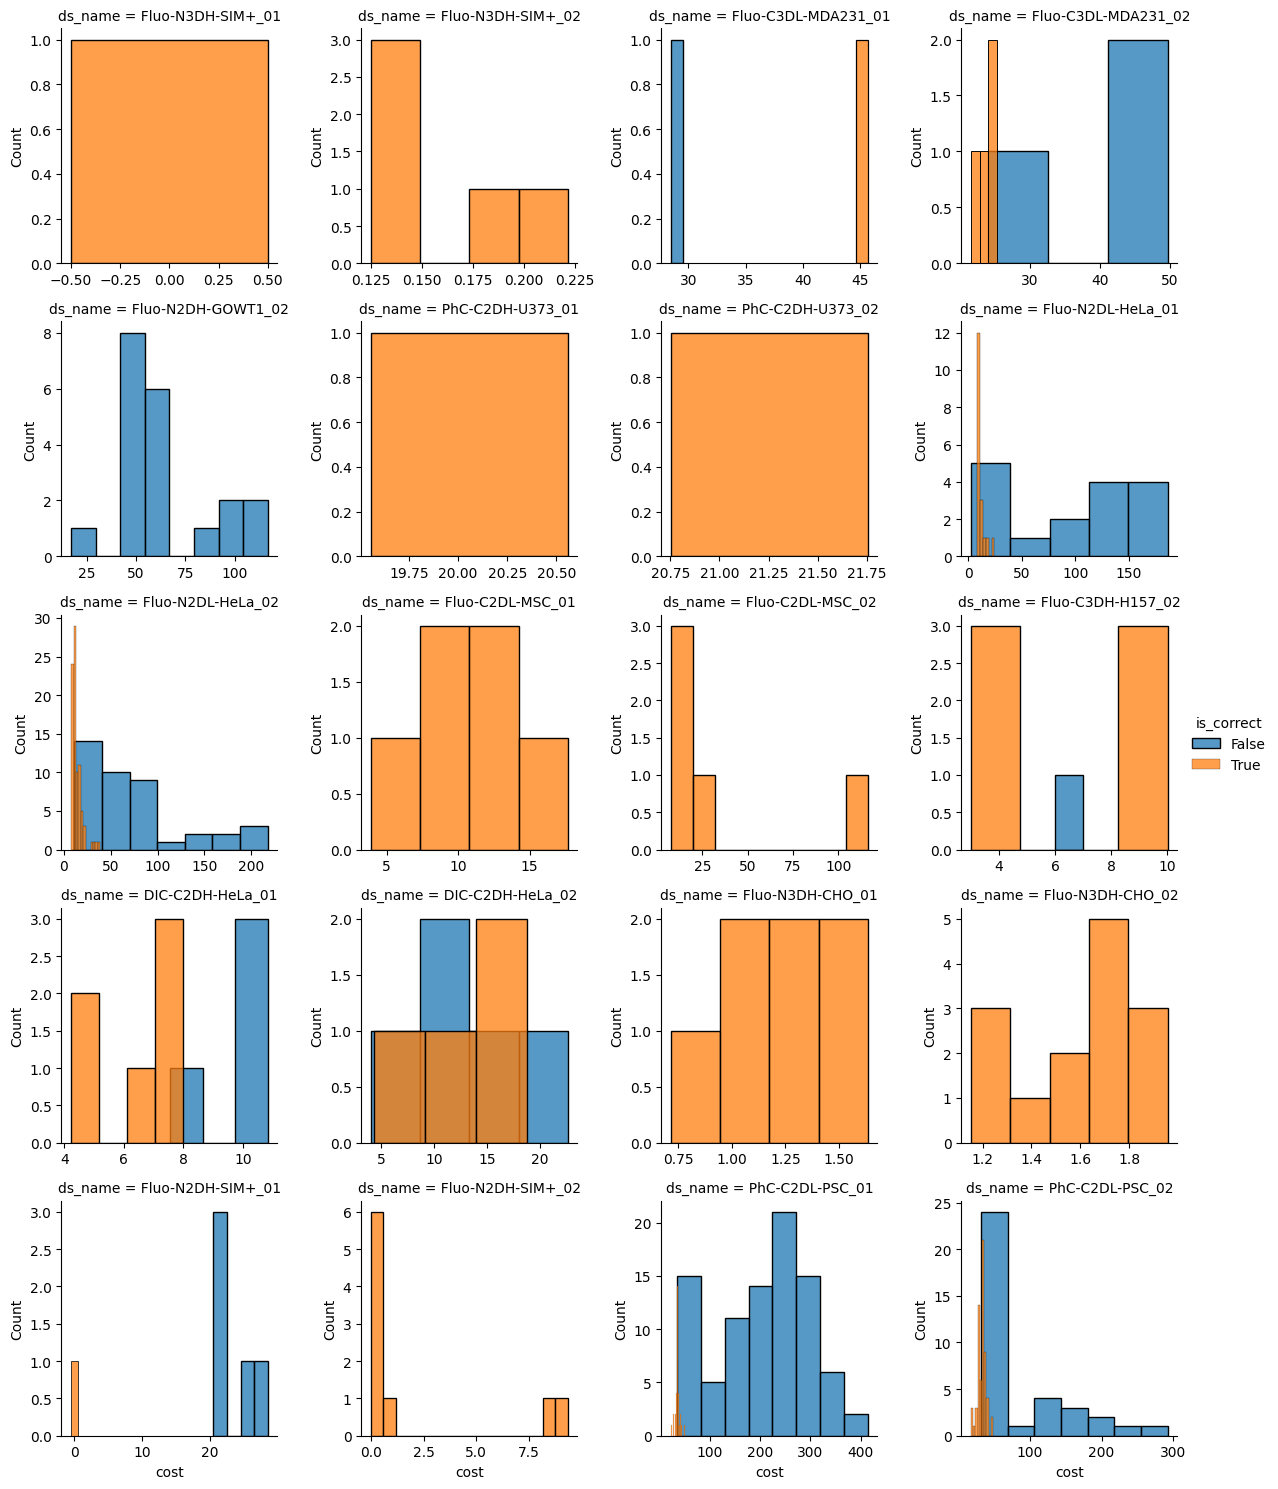

In [28]:
import seaborn as sns

grid = sns.FacetGrid(ap_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='cost')
grid.add_legend()

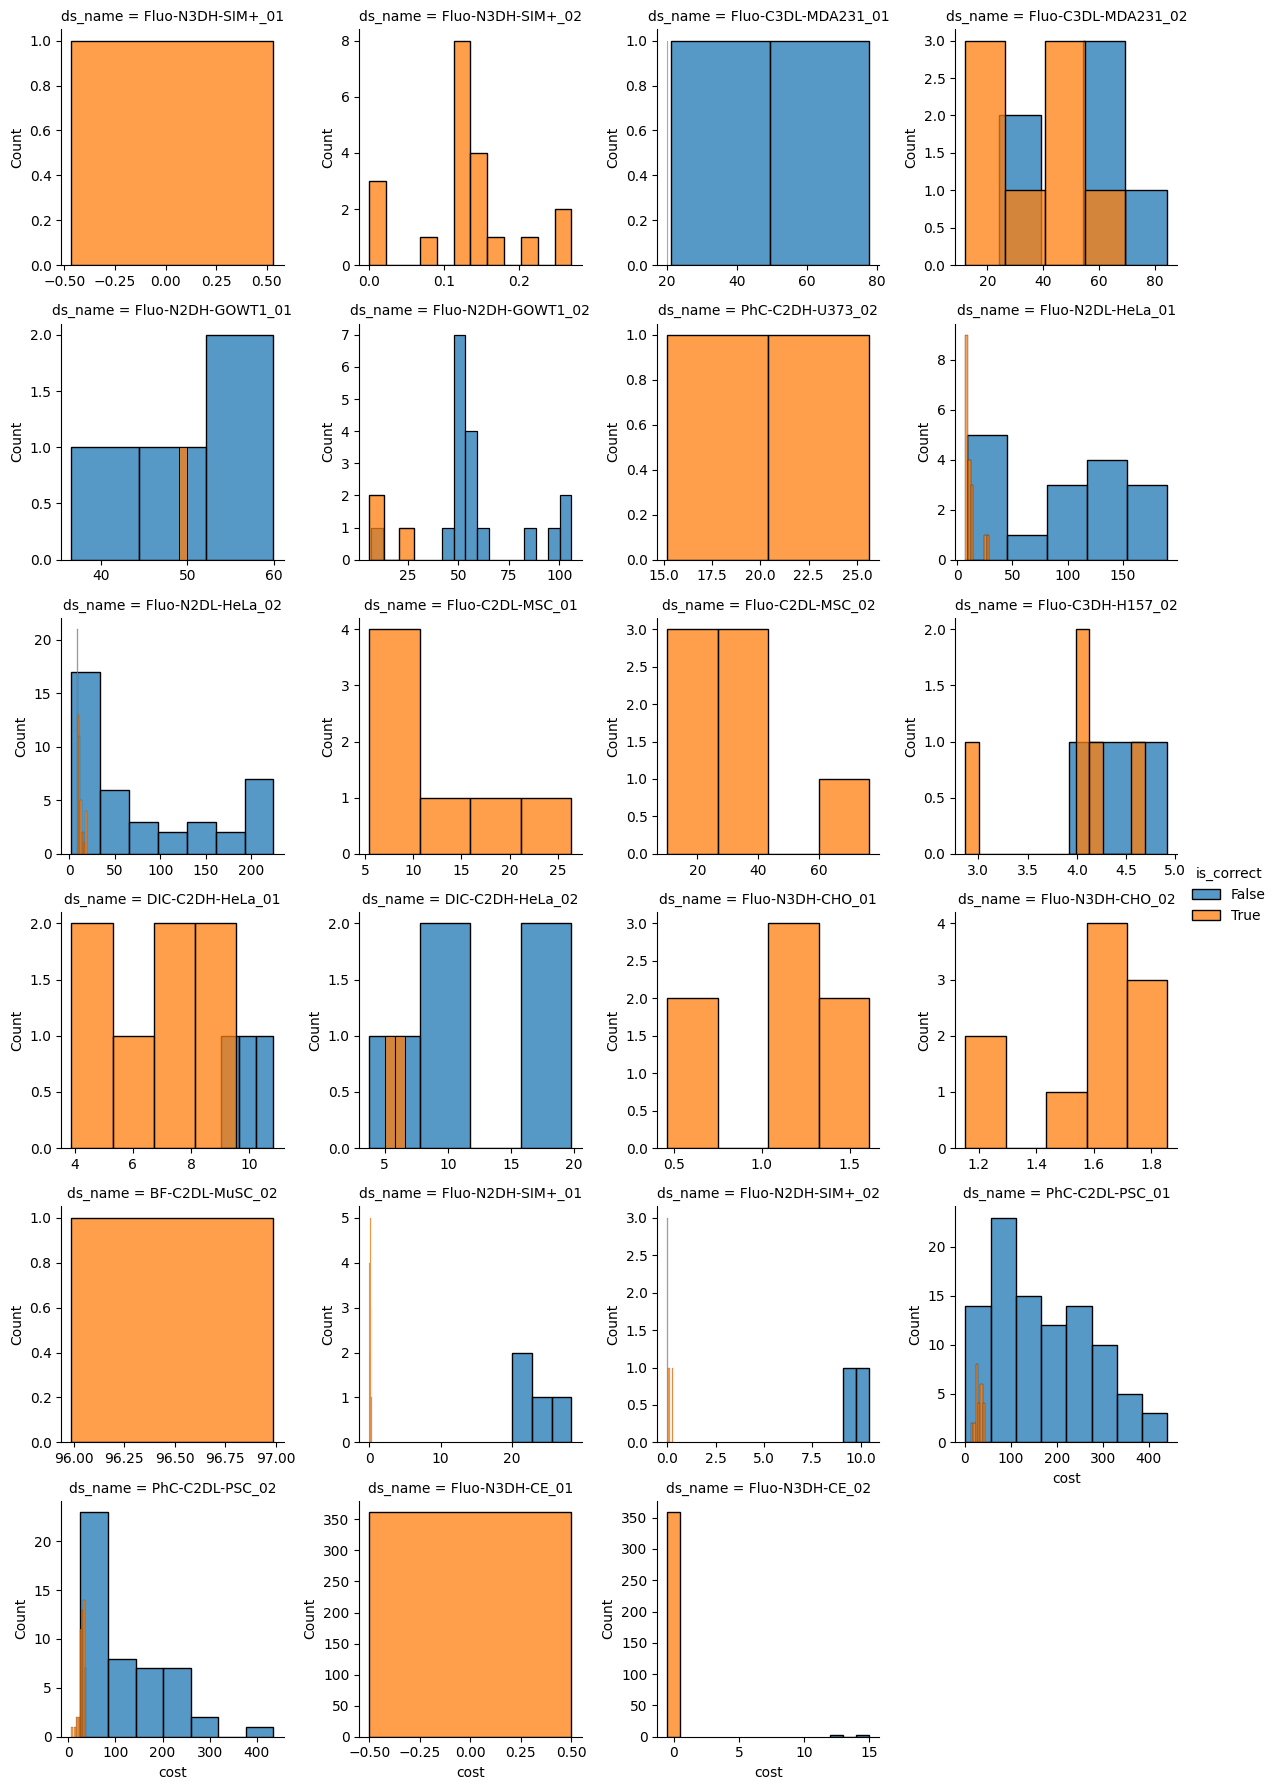

In [29]:
import seaborn as sns

grid = sns.FacetGrid(disap_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='cost')
grid.add_legend()

/tmp/ipykernel_5660/1820859608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_true_costs_ap['cost_diff'] = only_true_costs_ap['cost'] - only_true_costs_ap['real_cost']


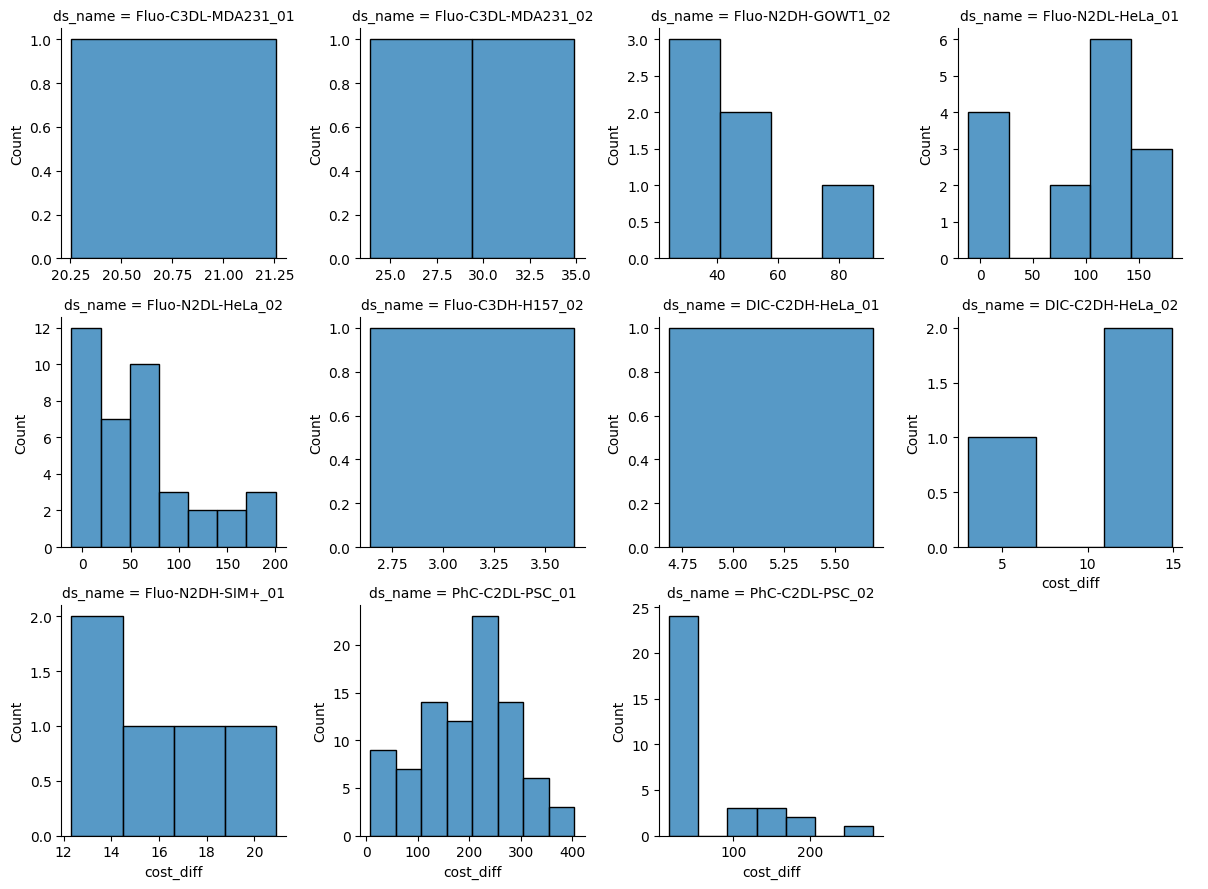

In [33]:
only_true_costs_ap = ap_df[(ap_df.is_fn == False) & (ap_df.is_correct == False)]
import seaborn as sns

only_true_costs_ap['cost_diff'] = only_true_costs_ap['cost'] - only_true_costs_ap['real_cost']

grid = sns.FacetGrid(only_true_costs_ap, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.histplot, x='cost_diff')
grid.add_legend()

/tmp/ipykernel_5660/1004068354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_true_costs_disap['cost_diff'] = only_true_costs_disap['cost'] - only_true_costs_disap['real_cost']


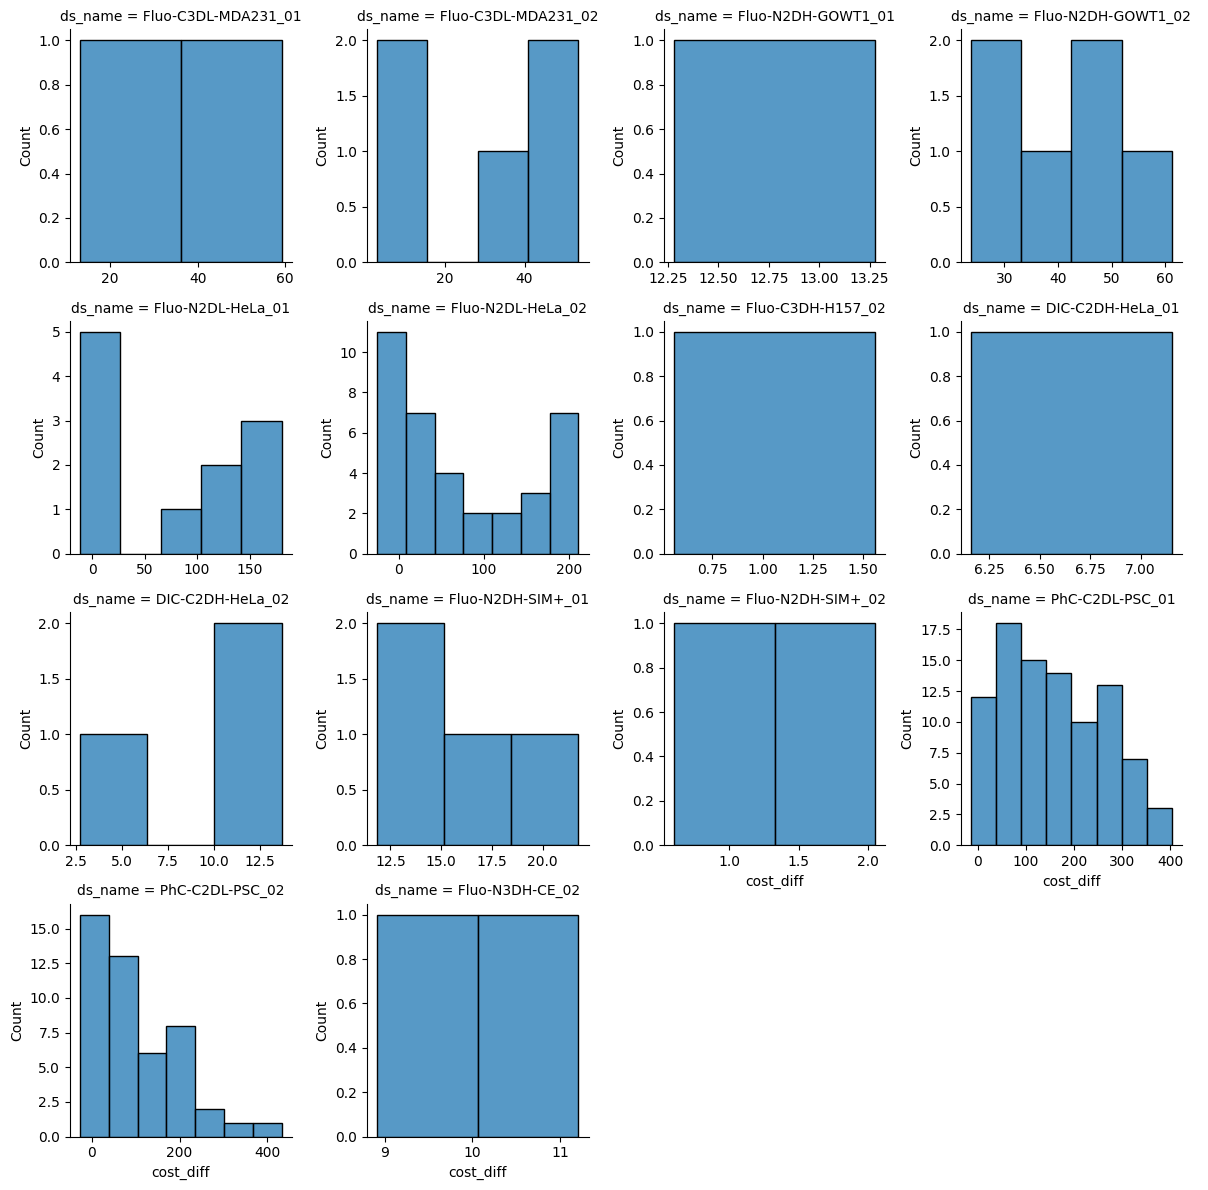

In [34]:
only_true_costs_disap = disap_df[(disap_df.is_fn == False) & (disap_df.is_correct == False)]
import seaborn as sns

only_true_costs_disap['cost_diff'] = only_true_costs_disap['cost'] - only_true_costs_disap['real_cost']

grid = sns.FacetGrid(only_true_costs_disap, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.histplot, x='cost_diff')
grid.add_legend()

In [ ]:
# TODO: investigate the length of a track segment before disappearance
# TODO: look at some appearances - why aren't they divisions? are they more likely in 3D data than in 2D?